# Problem    
  
Suppose you are a data scientist hired by a nonprofit organization whose mission is to advocate for better health outcomes for low income populations in the United States. You have been asked to examine whether low income groups are at greater risk for being diagnosed and dying from lung cancer. 

# Strategy    
    
As a data scientist, we will begin by looking for data. In this case, the US federal government has published open-source data fitting our present needs. Specifically cancer.gov has cancer incidence and mortality data, and the Census American Community Survey includes a multitude of additional variables that cam be useful to our analysis. 

**Our broad goals**:   
1. Demonstrate whether or not lung cancer incidence and mortality are correlated with socioeconomic status
2. Interpret results by providing both quantitative and visual evidence for the clients.

**Objectives**:    
1. Gather, clean and prepare data
2. Perform exploratory analysis
3. Develop statistical model
4. Visualize and interpret results
 

###   

In [1]:
# data wrangling tools
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# statistical analysis tool
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import time

# 1. Gather, Clean and Prepare Data   

### Cancer Incidence & Mortality Data
Cancer mortality and incidence data can be found at cancer.gov

For our analysis, we will using cancer statistics aggregated at the county level. In turn, we will be able to merge with data from the Census, also aggregated at the county level.

In [2]:

path = ''


In [3]:


#open the csv file in excel using pandas dataframe
mortdf = pd.read_csv('Cancer Analysis Data Files\death.csv', delimiter=',')

#incddf = pd.read_csv('incd.csv', delimiter=',')
incddf = pd.read_csv('Cancer Analysis Data Files\incd2.csv', delimiter=',')

mortdf.head()


,County,FIPS,Met Objective of 45.5? (1),Age-Adjusted Death Rate,Lower 95% Confidence Interval for Death Rate,Upper 95% Confidence Interval for Death Rate,Average Deaths per Year,Recent Trend (2),Recent 5-Year Trend (2) in Death Rates,Lower 95% Confidence Interval for Trend,Upper 95% Confidence Interval for Trend
0,United States,0,No,46,45.9,46.1,"157,376",falling,-2.4,-2.6,-2.2
1,"Perry County, Kentucky",21193,No,125.6,108.9,144.2,43,stable,-0.6,-2.7,1.6
2,"Powell County, Kentucky",21197,No,125.3,100.2,155.1,18,stable,1.7,0,3.4
3,"North Slope Borough, Alaska",2185,No,124.9,73,194.7,5,**,**,**,**
4,"Owsley County, Kentucky",21189,No,118.5,83.1,165.5,8,stable,2.2,-0.4,4.8


In [4]:
incddf.head()
incddf.FIPS

0           0
1        1001
2        1003
3        1005
4        1007
        ...  
3136    56037
3137    56039
3138    56041
3139    56043
3140    56045
Name: FIPS, Length: 3141, dtype: int64

In [5]:
mortdf.FIPS

0           0
1       21193
2       21197
3        2185
4       21189
        ...  
3136     2282
3137     2290
3138    48505
3139    48507
3140    46137
Name: FIPS, Length: 3141, dtype: int64

In [6]:
mortdf = mortdf[mortdf.FIPS.notnull()]
incddf = incddf[incddf.FIPS.notnull()]

mortdf['FIPS'] = mortdf.FIPS.apply(lambda x: str(int(x)))\
                            .astype(np.object_)\
                            .str.pad(5, 'left', '0')

incddf['FIPS'] = incddf.FIPS.apply(lambda x: str(int(x)))\
                            .astype(np.object_)\
                            .str.pad(5, 'left', '0')

incddf.drop(incddf.columns[[0,3,4,7,8,9]].values, axis=1, inplace=True)
mortdf.drop(mortdf.columns[[0,2,4,5,7,8,9,10]], axis=1, inplace=True)

incddf.rename(columns={incddf.columns[1]:'Incidence_Rate',
                       incddf.columns[2]:'Avg_Ann_Incidence'}, inplace=True)
mortdf.rename(columns={mortdf.columns[1]:'Mortality_Rate',
                       mortdf.columns[2]:'Avg_Ann_Deaths'}, inplace=True)

In [7]:
mortdf.head()

,FIPS,Mortality_Rate,Avg_Ann_Deaths
0,00000,46,"157,376"
1,21193,125.6,43
2,21197,125.3,18
3,02185,124.9,5
4,21189,118.5,8


In [8]:
incddf.head()

,FIPS,Incidence_Rate,Avg_Ann_Incidence,Recent Trend
0,00000,62.4,214614,falling
1,01001,74.9,43,stable
2,01003,66.9,170,stable
3,01005,74.6,25,stable
4,01007,86.4,23,stable


In [9]:
incddf.drop("Recent Trend", axis=1, inplace=True)
incddf.head()

,FIPS,Incidence_Rate,Avg_Ann_Incidence
0,00000,62.4,214614
1,01001,74.9,43
2,01003,66.9,170
3,01005,74.6,25
4,01007,86.4,23


### Census Data     
  
1. To join with incidence and mortality, we need data that are indexed by US County.
2. We're looking for variables which explain (are correlated with) incidence and mortality.
3. We want interesting (meaningful and relevant) variables. For example:
  * Poverty
  * Median Income
  * Educational Attainment
  * Employment
  * etc.

#### A. Poverty Data

We will select these data from the poverty file:

B17001_002
POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE for Population For Whom Poverty Status Is Determined% Income in the past 12 months below poverty level    
B17001_003
POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE for Population For Whom Poverty Status Is Determined% Income in the past 12 months below poverty level:% Male    
B17001_017
POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE for Population For Whom Poverty Status Is Determined% Income in the past 12 months below poverty level:% Female

In [10]:
import os
# assign directory
directory = 'Cancer Analysis Data Files/acs-2015-5-e-poverty/'

list_ = os.listdir(directory)
list_

['ak.csv',
 'al.csv',
 'ar.csv',
 'az.csv',
 'ca.csv',
 'co.csv',
 'ct.csv',
 'dc.csv',
 'de.csv',
 'fl.csv',
 'ga.csv',
 'hi.csv',
 'ia.csv',
 'id.csv',
 'il.csv',
 'in.csv',
 'ks.csv',
 'ky.csv',
 'la.csv',
 'ma.csv',
 'md.csv',
 'me.csv',
 'mi.csv',
 'mn.csv',
 'mo.csv',
 'ms.csv',
 'mt.csv',
 'nc.csv',
 'nd.csv',
 'ne.csv',
 'nh.csv',
 'nj.csv',
 'nm.csv',
 'nv.csv',
 'ny.csv',
 'oh.csv',
 'ok.csv',
 'or.csv',
 'pa.csv',
 'ri.csv',
 'sc.csv',
 'sd.csv',
 'tn.csv',
 'tx.csv',
 'ut.csv',
 'va.csv',
 'vt.csv',
 'wa.csv',
 'wi.csv',
 'wv.csv',
 'wy.csv']

In [11]:
#sort the states
list1_ = np.sort(list_)
list1_[1:]

array(['al.csv', 'ar.csv', 'az.csv', 'ca.csv', 'co.csv', 'ct.csv',
       'dc.csv', 'de.csv', 'fl.csv', 'ga.csv', 'hi.csv', 'ia.csv',
       'id.csv', 'il.csv', 'in.csv', 'ks.csv', 'ky.csv', 'la.csv',
       'ma.csv', 'md.csv', 'me.csv', 'mi.csv', 'mn.csv', 'mo.csv',
       'ms.csv', 'mt.csv', 'nc.csv', 'nd.csv', 'ne.csv', 'nh.csv',
       'nj.csv', 'nm.csv', 'nv.csv', 'ny.csv', 'oh.csv', 'ok.csv',
       'or.csv', 'pa.csv', 'ri.csv', 'sc.csv', 'sd.csv', 'tn.csv',
       'tx.csv', 'ut.csv', 'va.csv', 'vt.csv', 'wa.csv', 'wi.csv',
       'wv.csv', 'wy.csv'], dtype='<U6')

In [12]:
for i in list1_[1:]:
    print(i)

al.csv
ar.csv
az.csv
ca.csv
co.csv
ct.csv
dc.csv
de.csv
fl.csv
ga.csv
hi.csv
ia.csv
id.csv
il.csv
in.csv
ks.csv
ky.csv
la.csv
ma.csv
md.csv
me.csv
mi.csv
mn.csv
mo.csv
ms.csv
mt.csv
nc.csv
nd.csv
ne.csv
nh.csv
nj.csv
nm.csv
nv.csv
ny.csv
oh.csv
ok.csv
or.csv
pa.csv
ri.csv
sc.csv
sd.csv
tn.csv
tx.csv
ut.csv
va.csv
vt.csv
wa.csv
wi.csv
wv.csv
wy.csv


In [13]:
#take a look at one of the files
filename=directory+'ak.csv'
tdf = pd.read_csv(filename, delimiter=',')
tdf.head()

,summarylevel,state,statefips,countyfips,placefips,cbsacode,congressdistrict,geoid,areaname,b17001_001,...,b17026_004,b17026_005,b17026_006,b17026_007,b17026_008,b17026_009,b17026_010,b17026_011,b17026_012,b17026_013
0,40,AK,2,NaN,NaN,NaN,NaN,04000US02,Alaska,716218,...,3920,4605,5516,5315,2066,3599,22287,22591,20750,69145
1,40,AK,2,NaN,NaN,NaN,NaN,04001US02,Alaska -- Urban,471025,...,2172,2712,3406,3421,1319,2080,15001,15243,14322,47806
2,40,AK,2,NaN,NaN,NaN,NaN,04043US02,Alaska -- Rural,245193,...,1748,1893,2110,1894,747,1519,7286,7348,6428,21339
3,40,AK,2,NaN,NaN,NaN,NaN,040A0US02,Alaska -- In metropolitan or micropolitan stat...,527605,...,2387,2832,3771,3378,1403,2427,16191,17232,16161,55428
4,40,AK,2,NaN,NaN,NaN,NaN,040C0US02,Alaska -- In metropolitan statistical area,482151,...,2160,2644,3622,3117,1344,2219,14816,15748,14683,49936


In [14]:
#summarylevel 50: Counties and county equivalents      
cols = ['state','statefips', 'countyfips', 'areaName', 'b17001_002', 'b17001_003', 'b17001_017']
povdf1 = tdf.loc[tdf['summarylevel'] == 50]
povdf1
povdf = povdf1[povdf1.columns & cols]
povdf = povdf1.filter(cols)
povdf.head()


,state,statefips,countyfips,b17001_002,b17001_003,b17001_017
12,AK,2,13.0,553,334,219
13,AK,2,16.0,499,273,226
14,AK,2,20.0,23914,10698,13216
15,AK,2,50.0,4364,2199,2165
16,AK,2,60.0,69,33,36


In [15]:
tables_file = []
for i in list1_[1:]:
    tables_file.append(i)
tables_file
np.array(tables_file)

array(['al.csv', 'ar.csv', 'az.csv', 'ca.csv', 'co.csv', 'ct.csv',
       'dc.csv', 'de.csv', 'fl.csv', 'ga.csv', 'hi.csv', 'ia.csv',
       'id.csv', 'il.csv', 'in.csv', 'ks.csv', 'ky.csv', 'la.csv',
       'ma.csv', 'md.csv', 'me.csv', 'mi.csv', 'mn.csv', 'mo.csv',
       'ms.csv', 'mt.csv', 'nc.csv', 'nd.csv', 'ne.csv', 'nh.csv',
       'nj.csv', 'nm.csv', 'nv.csv', 'ny.csv', 'oh.csv', 'ok.csv',
       'or.csv', 'pa.csv', 'ri.csv', 'sc.csv', 'sd.csv', 'tn.csv',
       'tx.csv', 'ut.csv', 'va.csv', 'vt.csv', 'wa.csv', 'wi.csv',
       'wv.csv', 'wy.csv'], dtype='<U6')

In [16]:
# Retrieve the Census poverty data
start = time.time()

# a string - the poverty columns we want from the Census ACS 
cols = ['state','statefips', 'countyfips', 'areaname', 'b17001_002', 'b17001_003', 'b17001_017']

# call the data for each state and concatenate
for i in tables_file:
    filename=directory+i
    print(filename)
    tdf = pd.read_csv(filename, delimiter=',')
    if i == "ak.csv":
        #tdf.head()
        povdf1 = tdf.loc[tdf['summarylevel'] == 50]
        povdf1.head()
        povdf = povdf1.filter(cols)
    else:
        df1 = tdf.loc[tdf['summarylevel'] == 50]
        df=df1.filter(cols)
        povdf = pd.concat([povdf, df], ignore_index=True)

end = time.time()

print("Time to process", end - start)

povdf.tail()


Cancer Analysis Data Files/acs-2015-5-e-poverty/al.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/ar.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/az.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/ca.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/co.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/ct.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/dc.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/de.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/fl.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/ga.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/hi.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/ia.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/id.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/il.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/in.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/ks.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/ky.csv
Cancer Analysis Data Files/acs-2015-5-e-poverty/la.csv
Cancer Ana

,state,statefips,countyfips,b17001_002,b17001_003,b17001_017,areaname
3137,WY,56,37.0,5058,2177,2881,"Sweetwater County, Wyoming"
3138,WY,56,39.0,1638,1026,612,"Teton County, Wyoming"
3139,WY,56,41.0,2845,1453,1392,"Uinta County, Wyoming"
3140,WY,56,43.0,1137,489,648,"Washakie County, Wyoming"
3141,WY,56,45.0,958,354,604,"Weston County, Wyoming"


In [17]:
# Add leading zeros to the state and county FIPS codes
povdf['statefips'] = povdf.statefips.astype(np.object_)\
                                    .apply(lambda x: str(x))\
                                    .str.pad(2, 'left', '0')

povdf['countyfips'] = povdf['countyfips'].astype(int)
povdf['countyfips'] = povdf.countyfips.astype(np.object_)\
                                      .apply(lambda x: str(x))\
                                      .str.pad(3, 'left', '0')

povdf.rename(columns={'statefips':'StateFIPS', 'countyfips':'CountyFIPS', 'b17001_002':'All_Poverty', 'b17001_003':'M_Poverty', 'b17001_017':'F_Poverty'},
             inplace=True)

povdf.head()

,state,StateFIPS,CountyFIPS,All_Poverty,M_Poverty,F_Poverty,areaname
0,AK,02,013,553,334,219,NaN
1,AK,02,016,499,273,226,NaN
2,AK,02,020,23914,10698,13216,NaN
3,AK,02,050,4364,2199,2165,NaN
4,AK,02,060,69,33,36,NaN


In [18]:
povdf['CountyFIPS']

0       013
1       016
2       020
3       050
4       060
       ... 
3137    037
3138    039
3139    041
3140    043
3141    045
Name: CountyFIPS, Length: 3142, dtype: object

#### B. Income Data

We will select these columns from each of the income files.

B19013_001
MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) for Households%Median household income in the past 12 months (in 2015 Inflation-adjusted dollars)   


B19013A_001
MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) (WHITE ALONE HOUSEHOLDER) for Households With A Householder Who Is White Alone%Median household income in the past 12 months (in 2015 Inflation-adjusted dollars)       
       
B19013B_001
MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) (BLACK OR AFRICAN AMERICAN ALONE HOUSEHOLDER) for Households With A Householder Who Is Black Or African American Alone%Median household income in the past 12 months (in 2015 Inflation-adjusted dollars)       
       
B19013C_001
MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) (AMERICAN INDIAN AND ALASKA NATIVE ALONE HOUSEHOLDER) for Households With A Householder Who Is American Indian And Alaska Native Alone%Median household income in the past 12 months (in 2015 Inflation-adjusted dollars)       
            
B19013D_001
MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) (ASIAN ALONE HOUSEHOLDER) for Households With A Householder Who Is Asian Alone%Median household income in the past 12 months (in 2015 Inflation-adjusted dollars)  
       
B19013I_001
MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2015 INFLATION-ADJUSTED DOLLARS) (HISPANIC OR LATINO HOUSEHOLDER) for Households With A Householder Who Is Hispanic Or Latino%Median household income in the past 12 months (in 2015 Inflation-adjusted dollars)

In [19]:
directory1 = 'Cancer Analysis Data Files/acs-2015-5-e-income/'
list_ = os.listdir(directory1)
list_
list1_ = np.sort(list_)
list1_[1:]
tables_income = []
for i in list1_[1:]:
    tables_income.append(i)
tables_income
np.array(tables_income)

array(['AL.csv', 'AR.csv', 'AZ.csv', 'CA.csv', 'CO.csv', 'CT.csv',
       'DC.csv', 'DE.csv', 'FL.csv', 'GA.csv', 'HI.csv', 'IA.csv',
       'ID.csv', 'IL.csv', 'IN.csv', 'KS.csv', 'KY.csv', 'LA.csv',
       'MA.csv', 'MD.csv', 'ME.csv', 'MI.csv', 'MN.csv', 'MO.csv',
       'MS.csv', 'MT.csv', 'NC.csv', 'ND.csv', 'NE.csv', 'NH.csv',
       'NJ.csv', 'NM.csv', 'NV.csv', 'NY.csv', 'OH.csv', 'OK.csv',
       'OR.csv', 'PA.csv', 'RI.csv', 'SC.csv', 'SD.csv', 'TN.csv',
       'TX.csv', 'UT.csv', 'VA.csv', 'VT.csv', 'WA.csv', 'WI.csv',
       'WV.csv', 'WY.csv'], dtype='<U6')

In [20]:
filename=directory1+'AK.csv'
tdf = pd.read_csv(filename, delimiter=',')
tdf.head()

,SummaryLevel,State,StateFIPS,CountyFIPS,PlaceFIPS,CBSACode,CongressDistrict,GEOID,AreaName,B19001_001,...,B19325_093,B19325_094,B19325_095,B19326_001,B19326_002,B19326_003,B19326_004,B19326_005,B19326_006,B19326_007
0,40,AK,2,NaN,NaN,NaN,NaN,04000US02,Alaska,250969,...,2901,3526,2304,31455,39624,60570,18427,25071,46124,12576
1,40,AK,2,NaN,NaN,NaN,NaN,04001US02,Alaska -- Urban,169002,...,1855,2417,1544,33394,40734,58229,18477,27203,46465,13350
2,40,AK,2,NaN,NaN,NaN,NaN,04043US02,Alaska -- Rural,81967,...,1046,1109,760,27278,36222,64263,18360,20153,45259,11484
3,40,AK,2,NaN,NaN,NaN,NaN,040A0US02,Alaska -- In metropolitan or micropolitan stat...,189236,...,2214,2809,1894,33857,41804,60795,19244,26983,46998,12945
4,40,AK,2,NaN,NaN,NaN,NaN,040C0US02,Alaska -- In metropolitan statistical area,171855,...,1963,2570,1714,33441,41700,60451,19224,26508,46928,12762


In [21]:
cols = ['StateFIPS', 'CountyFIPS','B19013_001', 'B19013A_001', 'B19013B_001','B19013C_001', 'B19013D_001','B19013I_001']
start = time.time()
incomedf = pd.DataFrame()
for i in tables_income:
    filename=directory1+i
    print(filename)
    tdf = pd.read_csv(filename, delimiter=',')
    if i == "AK.csv":
        #tdf.head()
        incomedf = tdf.loc[tdf['SummaryLevel'] == 50]
        incomedf.head()
        incomedf = incomedf.filter(cols)
    else:
        df1 = tdf.loc[tdf['SummaryLevel'] == 50]
        df=df1.filter(cols)
        incomedf = pd.concat([incomedf, df], ignore_index=True)

print(end - start)

incomedf.head()

incomedf['StateFIPS'] = incomedf.StateFIPS.astype(np.object_)\
                                .apply(lambda x: str(x))\
                                .str.pad(2, 'left', '0')
incomedf['CountyFIPS'] = incomedf['CountyFIPS'].astype(int)
incomedf['CountyFIPS'] = incomedf.CountyFIPS.astype(np.object_)\
                                 .apply(lambda x: str(x))\
                                 .str.pad(3, 'left', '0')

incomedf.rename(columns={'B19013_001':'Med_Income', 'B19013A_001':'Med_Income_White', 
                         'B19013B_001':'Med_Income_Black', 'B19013C_001':'Med_Income_Nat_Am',
                         'B19013D_001':'Med_Income_Asian', 'B19013I_001':'Hispanic'}, inplace=True)

Cancer Analysis Data Files/acs-2015-5-e-income/AL.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (197,902,951,952,953,954,955,956,957,958,959,960,961,962,1383,1393) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/AR.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (198,205,906,937,938,941,963,1170,1171,1172,1174,1175,1179,1181,1182,1183,1184,1185,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1384,1391,1394,1401,1498) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/AZ.csv
Cancer Analysis Data Files/acs-2015-5-e-income/CA.csv
Cancer Analysis Data Files/acs-2015-5-e-income/CO.csv
Cancer Analysis Data Files/acs-2015-5-e-income/CT.csv
Cancer Analysis Data Files/acs-2015-5-e-income/DC.csv
Cancer Analysis Data Files/acs-2015-5-e-income/DE.csv
Cancer Analysis Data Files/acs-2015-5-e-income/FL.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (179,180,181,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,897,898,899,900,901,902,903,904,905,906,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,1134,1135,1136,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1342,1343,1344,1349,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,

Cancer Analysis Data Files/acs-2015-5-e-income/GA.csv
Cancer Analysis Data Files/acs-2015-5-e-income/HI.csv
Cancer Analysis Data Files/acs-2015-5-e-income/IA.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (179,180,187,189,197,198,205,897,901,902,905,906,937,938,940,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,1170,1171,1172,1173,1174,1182,1183,1184,1185,1187,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1383,1384,1391,1393,1394,1401,1498,1499,1502) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/ID.csv
Cancer Analysis Data Files/acs-2015-5-e-income/IL.csv
Cancer Analysis Data Files/acs-2015-5-e-income/IN.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (906) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/KS.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (197,198,205,902,937,938,951,952,953,954,955,956,957,958,959,960,961,962,963,1170,1171,1172,1174,1182,1185,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1383,1384,1391,1393,1394,1401,1498) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/KY.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (198,205,905,906,937,938,941,1170,1171,1172,1173,1174,1182,1183,1184,1185,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1384,1391,1394,1401) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/LA.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (179,189,191,197,897,899,900,901,902,904,905,906,937,938,941,944,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,1134,1144,1145,1151,1153,1154,1156,1157,1158,1159,1160,1162,1170,1171,1172,1173,1174,1182,1184,1185,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1352,1368,1369,1370,1371,1372,1373,1374,1376,1377,1378,1379,1380,1381,1383,1393,1498,1499,1500,1501,1502,1503,1504) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/MA.csv
Cancer Analysis Data Files/acs-2015-5-e-income/MD.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (197,198,205,902,906,951,952,953,954,955,956,957,958,959,960,961,962,1383,1384,1391,1393,1394,1401) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/ME.csv
Cancer Analysis Data Files/acs-2015-5-e-income/MI.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (179,189,897,904,937,938,940,941,946,947,948,949,950,963,1134,1144,1151,1156,1158,1159,1173,1174,1183,1201,1208,1498,1499,1501,1502,1504) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/MN.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (179,180,181,182,183,185,186,187,188,189,190,191,192,193,194,195,196,198,199,200,201,203,204,205,206,897,898,899,900,901,903,904,906,937,938,939,940,941,942,943,944,945,946,947,948,949,950,963,1134,1135,1136,1137,1138,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1342,1343,1349,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1384,1385,1386,1387,1388,1389,1390,1391,1392,1394,1395,1396,1397,1398,1399,1400,1401,1402,1498,1499,1500,1

Cancer Analysis Data Files/acs-2015-5-e-income/MO.csv
Cancer Analysis Data Files/acs-2015-5-e-income/MS.csv
Cancer Analysis Data Files/acs-2015-5-e-income/MT.csv
Cancer Analysis Data Files/acs-2015-5-e-income/NC.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (197,902,905,906,937,938,951,952,953,954,955,956,957,958,959,960,961,962,963,1170,1171,1172,1174,1182,1183,1184,1185,1189,1190,1194,1195,1196,1197,1198,1383,1384,1391,1393,1498) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/ND.csv
Cancer Analysis Data Files/acs-2015-5-e-income/NE.csv
Cancer Analysis Data Files/acs-2015-5-e-income/NH.csv
Cancer Analysis Data Files/acs-2015-5-e-income/NJ.csv
Cancer Analysis Data Files/acs-2015-5-e-income/NM.csv
Cancer Analysis Data Files/acs-2015-5-e-income/NV.csv
Cancer Analysis Data Files/acs-2015-5-e-income/NY.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1383,1384,1391,1393,1394,1401,1498,1502) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/OH.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (197,198,205,902,937,951,952,953,954,955,956,957,958,959,960,961,962,1383,1384,1391,1393,1394,1401) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/OK.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1383) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/OR.csv
Cancer Analysis Data Files/acs-2015-5-e-income/PA.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1383,1384,1391,1393,1394,1401) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/RI.csv
Cancer Analysis Data Files/acs-2015-5-e-income/SC.csv
Cancer Analysis Data Files/acs-2015-5-e-income/SD.csv
Cancer Analysis Data Files/acs-2015-5-e-income/TN.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (193,900,904,939,940,1134,1135,1142,1144,1151,1156,1159,1160,1175,1176,1177,1178,1179,1180,1181,1187,1191,1192,1193,1195,1196,1198,1199,1200,1201,1202,1203,1204,1205,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1352,1368,1369,1370,1371,1372,1376,1377,1378,1379,1500,1502) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/TX.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (179,180,185,187,188,189,190,191,192,193,194,195,196,197,198,199,203,205,206,897,898,899,900,901,902,903,904,905,906,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,1134,1135,1140,1142,1143,1144,1145,1146,1147,1148,1149,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1209,1210,1211,1212,1213,1214,1215,1216,1217,1342,1343,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1361,1362,1363,1364,1365,1366,1368,1369,1370,1371,1372,1373,1374,1376,1377,1378,1379,1380,1381,1383,1384,1385,1389,1391,1392,1393,1394,1395,1399,1401,1402,1498,1499,1500,1501,1502,1503,1504) have mixed types.Specify dty

Cancer Analysis Data Files/acs-2015-5-e-income/UT.csv
Cancer Analysis Data Files/acs-2015-5-e-income/VA.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (906,1170,1171,1172,1174,1182,1184,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1498) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/VT.csv
Cancer Analysis Data Files/acs-2015-5-e-income/WA.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (197,902,937,938,951,952,953,954,955,956,957,958,959,960,961,962,1170,1171,1172,1174,1182,1183,1184,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1383,1384,1391,1393,1394,1401) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/WI.csv


C:\Users\vbohra167040\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (179,189,897,906,946,947,948,949,950,1134,1144,1151,1156,1159,1173,1183,1201,1498,1499,1502,1504) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Cancer Analysis Data Files/acs-2015-5-e-income/WV.csv
Cancer Analysis Data Files/acs-2015-5-e-income/WY.csv
-196.58871626853943


In [22]:
incomedf.head()

,StateFIPS,CountyFIPS,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,Med_Income_Asian,Hispanic
0,01,001,51281,56854,32073,NaN,2499,61296
1,01,003,50254,52594,26967,92670,36250,42468
2,01,005,32964,45039,21171,.,NaN,27132
3,01,007,38678,42263,27793,.,.,43750
4,01,009,45813,46601,31507,61310,NaN,35271


In [23]:
directory2 = 'Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/'
list_ = os.listdir(directory2)
list_
list1_ = np.sort(list_)
list1_[1:]
tables_hins = []
for i in list1_[1:]:
    tables_hins.append(i)
tables_hins
np.array(tables_hins)

array(['AL.csv', 'AR.csv', 'AZ.csv', 'CA.csv', 'CO.csv', 'CT.csv',
       'DC.csv', 'DE.csv', 'FL.csv', 'GA.csv', 'HI.csv', 'IA.csv',
       'ID.csv', 'IL.csv', 'IN.csv', 'KS.csv', 'KY.csv', 'LA.csv',
       'MA.csv', 'MD.csv', 'ME.csv', 'MI.csv', 'MN.csv', 'MO.csv',
       'MS.csv', 'MT.csv', 'NC.csv', 'ND.csv', 'NE.csv', 'NH.csv',
       'NJ.csv', 'NM.csv', 'NV.csv', 'NY.csv', 'OH.csv', 'OK.csv',
       'OR.csv', 'PA.csv', 'RI.csv', 'SC.csv', 'SD.csv', 'TN.csv',
       'TX.csv', 'UT.csv', 'VA.csv', 'VT.csv', 'WA.csv', 'WI.csv',
       'WV.csv', 'WY.csv'], dtype='<U6')

#### C. Health Insurance Data

In each of the insurance files, we will select these columns.

B27001_004
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% Under 6 years            
B27001_005
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% Under 6 years:% With health insurance coverage       
B27001_007
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 6 to 17 years:% With health insurance coverage            
B27001_008
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 6 to 17 years:% No health insurance coverage               
B27001_010
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 18 to 24 years:% With health insurance coverage          
B27001_011
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 18 to 24 years:% No health insurance coverage            
B27001_013
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 25 to 34 years:% With health insurance coverage             
B27001_014
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 25 to 34 years:% No health insurance coverage             
B27001_016
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 35 to 44 years:% With health insurance coverage          
B27001_017
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 35 to 44 years:% No health insurance coverage              
B27001_019
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 45 to 54 years:% With health insurance coverage        
B27001_020
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 45 to 54 years:% No health insurance coverage          
B27001_022
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 55 to 64 years:% With health insurance coverage            
B27001_023
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 55 to 64 years:% No health insurance coverage           
B27001_025
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 65 to 74 years:% With health insurance coverage              
B27001_026
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 65 to 74 years:% No health insurance coverage             
B27001_028
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 75 years and over:% With health insurance coverage            
B27001_029
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Male:% 75 years and over:% No health insurance coverage               
B27001_032
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% Under 6 years:                 
B27001_033
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% Under 6 years:% With health insurance coverage       
B27001_035
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 6 to 17 years:% With health insurance coverage         
B27001_036
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 6 to 17 years:% No health insurance coverage            
B27001_038
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 18 to 24 years:% With health insurance coverage               
B27001_039
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 18 to 24 years:% No health insurance coverage              
B27001_041
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 25 to 34 years:% With health insurance coverage            
B27001_042
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 25 to 34 years:% No health insurance coverage          
B27001_044
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 35 to 44 years:% With health insurance coverage          
B27001_045
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 35 to 44 years:% No health insurance coverage          
B27001_047
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 45 to 54 years:% With health insurance coverage             
B27001_048
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 45 to 54 years:% No health insurance coverage           
B27001_050
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 55 to 64 years:% With health insurance coverage          
B27001_051
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 55 to 64 years:% No health insurance coverage           
B27001_053
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 65 to 74 years:% With health insurance coverage            
B27001_054
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 65 to 74 years:% No health insurance coverage              
B27001_056
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 75 years and over:% With health insurance coverage          
B27001_057
HEALTH INSURANCE COVERAGE STATUS BY SEX BY AGE for Civilian Noninstitutionalized Population% Female:% 75 years and over:% No health insurance coverage           

In [24]:
cols = ['StateFIPS', 'CountyFIPS',\
           'B27001_004', 'B27001_005', 'B27001_007', 'B27001_008', \
           'B27001_010', 'B27001_011', 'B27001_013', 'B27001_014', \
           'B27001_016', 'B27001_017', 'B27001_019', 'B27001_020', \
           'B27001_022', 'B27001_023', 'B27001_025', 'B27001_026', \
           'B27001_028', 'B27001_029', 'B27001_032', 'B27001_033', \
           'B27001_035', 'B27001_036', 'B27001_038', 'B27001_039', \
           'B27001_041', 'B27001_042', 'B27001_044', 'B27001_045', \
           'B27001_047', 'B27001_048', 'B27001_050', 'B27001_051', \
           'B27001_053', 'B27001_054', 'B27001_056', 'B27001_057']
# male <= 029   

start = time.time()
hinsdf = pd.DataFrame()

for i in tables_hins:
    filename=directory2+i
    print(filename)
    tdf = pd.read_csv(filename, delimiter=',')
    if i == "AK.csv":
        #tdf.head()
        hinsdf = tdf.loc[tdf['SummaryLevel'] == 50]
        hinsdf1.head()
        hinsdf = hinsdf.filter(cols)
    else:
        df1 = tdf.loc[tdf['SummaryLevel'] == 50]
        df=df1.filter(cols)
        hinsdf = pd.concat([hinsdf, df], ignore_index=True)

hinsdf.head()

end = time.time()
print(end - start)

hinsdf['StateFIPS'] = hinsdf.StateFIPS.astype(np.object_)\
                                      .apply(lambda x: str(x))\
                                      .str.pad(2, 'left', '0')
hinsdf['CountyFIPS'] = hinsdf['CountyFIPS'].astype(int)
hinsdf['CountyFIPS'] = hinsdf.CountyFIPS.astype(np.object_)\
                                        .apply(lambda x: str(x))\
                                        .str.pad(3, 'left', '0')

Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/AL.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/AR.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/AZ.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/CA.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/CO.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/CT.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/DC.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/DE.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/FL.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/GA.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/HI.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/IA.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/ID.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/IL.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance/IN.csv
Cancer Analysis Data Files/acs-2015-5-e-healthinsurance

In [25]:
hinsdf.head()

,StateFIPS,CountyFIPS,B27001_004,B27001_005,B27001_007,B27001_008,B27001_010,B27001_011,B27001_013,B27001_014,...,B27001_044,B27001_045,B27001_047,B27001_048,B27001_050,B27001_051,B27001_053,B27001_054,B27001_056,B27001_057
0,01,001,2004,6,4848,177,1928,563,2468,653,...,3191,687,3571,506,2998,239,2552,7,1605,0
1,01,003,6425,219,14899,590,5061,2188,7135,3689,...,10491,2052,11708,2311,12598,1662,10970,7,7662,0
2,01,005,990,22,1777,207,681,332,945,677,...,1069,245,1433,262,1546,200,1337,35,999,0
3,01,007,642,0,1809,48,683,301,1179,193,...,1238,393,1081,146,1268,88,979,0,728,0
4,01,009,1931,114,4610,266,1982,383,2384,1032,...,2990,743,3476,569,3428,415,3061,15,1967,2


In [26]:
# columns representing males' health insurance statistics
males = ['`B27001_004`', '`B27001_005`', '`B27001_007`', '`B27001_008`',
           '`B27001_010`', '`B27001_011`', '`B27001_013`', '`B27001_014`',
           '`B27001_016`', '`B27001_017`', '`B27001_019`', '`B27001_020`',
           '`B27001_022`', '`B27001_023`', '`B27001_025`', '`B27001_026`',
           '`B27001_028`', '`B27001_029`']

# females' health insurance statistics
females = ['`B27001_032`', '`B27001_033`', '`B27001_035`', '`B27001_036`', 
           '`B27001_038`', '`B27001_039`', '`B27001_041`', '`B27001_042`', 
           '`B27001_044`', '`B27001_045`', '`B27001_047`', '`B27001_048`', 
           '`B27001_050`', '`B27001_051`', '`B27001_053`', '`B27001_054`', 
           '`B27001_056`', '`B27001_057`']

# separate the "with" and "without" health insurance columns
males_with = []
males_without = []
females_with = []
females_without = []

# strip the backticks
for i, j in enumerate(males):
    if i % 2 == 0:
        males_with.append(j.replace('`', ''))
    else:
        males_without.append(j.replace('`', ''))
        
for i, j in enumerate(females):
    if i % 2 == 0:
        females_with.append(j.replace('`', ''))
    else:
        females_without.append(j.replace('`', ''))

# Create features that sum all the individual age group
clist = [males_with, males_without, females_with, females_without]
newcols = ['M_With', 'M_Without', 'F_With', 'F_Without'] 

for col in newcols:
    hinsdf[col] = 0

for i in males_with:
    hinsdf['M_With'] += hinsdf[i]  
for i in males_without:
    hinsdf['M_Without'] += hinsdf[i]
for i in females_with:
    hinsdf['F_With'] += hinsdf[i]
for i in females_without:
    hinsdf['F_Without'] += hinsdf[i]

hinsdf['All_With'] = hinsdf.M_With + hinsdf.F_With
hinsdf['All_Without'] = hinsdf.M_Without + hinsdf.F_Without

# Remove all the individual age group variables
# but, save them as a df called hinsdf_extra (just in case)
hinsdf_extra = df.loc[:, df.columns[df.columns.str.contains('B27001')].values]
hinsdf.drop(df.columns[df.columns.str.contains('B27001')].values, axis=1, inplace=True)

In [27]:
hinsdf.head()

,StateFIPS,CountyFIPS,M_With,M_Without,F_With,F_Without,All_With,All_Without
0,01,001,23500,2781,25417,2727,48917,5508
1,01,003,79768,13644,88015,11343,167783,24987
2,01,005,9578,2163,10750,1569,20328,3732
3,01,007,9342,1012,9421,995,18763,2007
4,01,009,24629,3642,25922,3017,50551,6659


### Merge DataFrames    
We're going to merge on the FIPS column. It's a 5-digit code. The first 2 digits are the 2-digit FIPS state code. The third, fourth, and fifth are the 3-digit FIPS county code.

1. First, let's create a "FIPS" in each dataframe by concatenating the state and county codes.   
2. Then, let's check to make sure that they properly match up.

In [28]:
dfs = [povdf, incomedf, hinsdf, incddf, mortdf]
dfs

[     state StateFIPS CountyFIPS  All_Poverty  M_Poverty  F_Poverty  \
 0       AK        02        013          553        334        219   
 1       AK        02        016          499        273        226   
 2       AK        02        020        23914      10698      13216   
 3       AK        02        050         4364       2199       2165   
 4       AK        02        060           69         33         36   
 ...    ...       ...        ...          ...        ...        ...   
 3137    WY        56        037         5058       2177       2881   
 3138    WY        56        039         1638       1026        612   
 3139    WY        56        041         2845       1453       1392   
 3140    WY        56        043         1137        489        648   
 3141    WY        56        045          958        354        604   
 
                         areaname  
 0                            NaN  
 1                            NaN  
 2                            NaN  
 3

In [29]:
dfs

[     state StateFIPS CountyFIPS  All_Poverty  M_Poverty  F_Poverty  \
 0       AK        02        013          553        334        219   
 1       AK        02        016          499        273        226   
 2       AK        02        020        23914      10698      13216   
 3       AK        02        050         4364       2199       2165   
 4       AK        02        060           69         33         36   
 ...    ...       ...        ...          ...        ...        ...   
 3137    WY        56        037         5058       2177       2881   
 3138    WY        56        039         1638       1026        612   
 3139    WY        56        041         2845       1453       1392   
 3140    WY        56        043         1137        489        648   
 3141    WY        56        045          958        354        604   
 
                         areaname  
 0                            NaN  
 1                            NaN  
 2                            NaN  
 3

In [30]:
# create FIPS features
for df in [povdf, incomedf, hinsdf]:
    df['FIPS'] = df.StateFIPS + df.CountyFIPS
    df.drop(['StateFIPS', 'CountyFIPS'], axis=1, inplace=True)

In [31]:
# use the pandas isin() method to see the intersections of FIPS features
# across dataframes
[[i, ii, sum(pd.Series(j.FIPS.unique()).isin(dfs[ii].FIPS))] 
    for i, j in enumerate(dfs) for ii in range(len(dfs))]

[[0, 0, 3142],
 [0, 1, 3113],
 [0, 2, 3113],
 [0, 3, 3134],
 [0, 4, 3134],
 [1, 0, 3113],
 [1, 1, 3113],
 [1, 2, 3113],
 [1, 3, 3111],
 [1, 4, 3111],
 [2, 0, 3113],
 [2, 1, 3113],
 [2, 2, 3113],
 [2, 3, 3111],
 [2, 4, 3111],
 [3, 0, 3134],
 [3, 1, 3111],
 [3, 2, 3111],
 [3, 3, 3141],
 [3, 4, 3141],
 [4, 0, 3134],
 [4, 1, 3111],
 [4, 2, 3111],
 [4, 3, 3141],
 [4, 4, 3141]]

In [32]:
# look at the number of unique FIPS values per dataframe
for i in dfs:
    print(len(i.FIPS.unique()))

3142
3113
3113
3141
3141


In [34]:
# check to see if all the FIPS values are 5 digits in length
dfs = [povdf, incomedf, hinsdf, incddf, mortdf] # our 5 dataframes to merge
for i, j in enumerate(dfs):
    lens = []
    for fips in j.FIPS.values:
        lens.append(len(fips))
    print(pd.Series(lens).value_counts(), '\n', '-'*10)    

5    3142
dtype: int64 
 ----------
5    3113
dtype: int64 
 ----------
5    3113
dtype: int64 
 ----------
5    3141
dtype: int64 
 ----------
5    3141
dtype: int64 
 ----------


It appears that the FIPS column in each dataframe is formatted well and they match up. Next, we will join them together into one large dataframe.

In [35]:
for i, j in enumerate(dfs):
    if i == 0:
        fulldf = j.copy()
    else:
        fulldf = fulldf.merge(j, how='inner', on='FIPS')
fulldf

,state,All_Poverty,M_Poverty,F_Poverty,areaname,FIPS,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,...,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Mortality_Rate,Avg_Ann_Deaths
0,AL,7057,2983,4074,"Autauga County, Alabama",01001,51281,56854,32073,NaN,...,23500,2781,25417,2727,48917,5508,74.9,43,59.3,34
1,AL,25798,12018,13780,"Baldwin County, Alabama",01003,50254,52594,26967,92670,...,79768,13644,88015,11343,167783,24987,66.9,170,48,121
2,AL,6421,2856,3565,"Barbour County, Alabama",01005,32964,45039,21171,.,...,9578,2163,10750,1569,20328,3732,74.6,25,61.3,20
3,AL,3488,1495,1993,"Bibb County, Alabama",01007,38678,42263,27793,.,...,9342,1012,9421,995,18763,2007,86.4,23,67.8,17
4,AL,9552,4593,4959,"Blount County, Alabama",01009,45813,46601,31507,61310,...,24629,3642,25922,3017,50551,6659,69.7,51,59.9,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,WY,5058,2177,2881,"Sweetwater County, Wyoming",56037,69022,69333,23535,NaN,...,19891,3318,18600,2683,38491,6001,39.9,14,28.4,9
3107,WY,1638,1026,612,"Teton County, Wyoming",56039,75325,77651,.,.,...,8948,2558,9555,1192,18503,3750,23.7,5,29.1,5
3108,WY,2845,1453,1392,"Uinta County, Wyoming",56041,56569,56532,.,.,...,9132,1413,8711,1503,17843,2916,31.7,6,22.1,4
3109,WY,1137,489,648,"Washakie County, Wyoming",56043,47652,48110,.,.,...,3349,691,3490,703,6839,1394,50,6,38.2,5


# 2. Perform Exploratory Analysis

In [36]:
fulldf.shape

(3111, 22)

In [37]:
fulldf.head()

,state,All_Poverty,M_Poverty,F_Poverty,areaname,FIPS,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,...,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Mortality_Rate,Avg_Ann_Deaths
0,AL,7057,2983,4074,"Autauga County, Alabama",01001,51281,56854,32073,NaN,...,23500,2781,25417,2727,48917,5508,74.9,43,59.3,34
1,AL,25798,12018,13780,"Baldwin County, Alabama",01003,50254,52594,26967,92670,...,79768,13644,88015,11343,167783,24987,66.9,170,48,121
2,AL,6421,2856,3565,"Barbour County, Alabama",01005,32964,45039,21171,.,...,9578,2163,10750,1569,20328,3732,74.6,25,61.3,20
3,AL,3488,1495,1993,"Bibb County, Alabama",01007,38678,42263,27793,.,...,9342,1012,9421,995,18763,2007,86.4,23,67.8,17
4,AL,9552,4593,4959,"Blount County, Alabama",01009,45813,46601,31507,61310,...,24629,3642,25922,3017,50551,6659,69.7,51,59.9,43


In [38]:
fulldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3111 entries, 0 to 3110
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   state              3111 non-null   object
 1   All_Poverty        3111 non-null   int64 
 2   M_Poverty          3111 non-null   int64 
 3   F_Poverty          3111 non-null   int64 
 4   areaname           3111 non-null   object
 5   FIPS               3111 non-null   object
 6   Med_Income         3110 non-null   object
 7   Med_Income_White   3109 non-null   object
 8   Med_Income_Black   2812 non-null   object
 9   Med_Income_Nat_Am  2603 non-null   object
 10  Med_Income_Asian   2673 non-null   object
 11  Hispanic           2700 non-null   object
 12  M_With             3111 non-null   int64 
 13  M_Without          3111 non-null   int64 
 14  F_With             3111 non-null   int64 
 15  F_Without          3111 non-null   int64 
 16  All_With           3111 non-null   int64 


In [39]:
# check for null values
for col in fulldf.columns:
    print((col, sum(fulldf[col].isnull())))

('state', 0)
('All_Poverty', 0)
('M_Poverty', 0)
('F_Poverty', 0)
('areaname', 0)
('FIPS', 0)
('Med_Income', 1)
('Med_Income_White', 2)
('Med_Income_Black', 299)
('Med_Income_Nat_Am', 508)
('Med_Income_Asian', 438)
('Hispanic', 411)
('M_With', 0)
('M_Without', 0)
('F_With', 0)
('F_Without', 0)
('All_With', 0)
('All_Without', 0)
('Incidence_Rate', 0)
('Avg_Ann_Incidence', 0)
('Mortality_Rate', 0)
('Avg_Ann_Deaths', 0)


The median income by ethnicity data is incomplete. We won't use them in our analysis.

In [40]:
fulldf.drop(['Med_Income_White', 'Med_Income_Black', 'Med_Income_Nat_Am',
             'Med_Income_Asian', 'Hispanic'], axis=1, inplace=True)

Let's create a data dictionary

In [41]:
data_dict = pd.DataFrame(fulldf.columns.values, index=range(len(fulldf.columns)), columns=['Feature'])

data_dict['Definition'] = ['','','Both male and female reported below poverty line (Raw)', 
                           'Males below poverty (Raw)', 'Females below poverty (Raw)', 'State + County FIPS (Raw)',
                           'Med_Income all enthnicities (Raw)', 'Males with health insurance (Raw)',
                           'Males without health insurance (Raw)', 'Females with health insurance (Raw)',
                           'Females without health insurance (Raw)', 'Males and Femaes with health ins. (Raw)',
                           'Males an Females without health ins (Raw)', 'Lung cancer incidence rate (per 100,000)',
                           'Average lung cancer incidence rate (Raw)', 'Recent trend (incidence)', 
                           'Lung cancer mortality rate (per 100,000)', 'Average lung cancer mortalities (Raw)']

data_dict['Notes'] = ''
data_dict.loc[[13,16], 'Notes'] = "'*' = fewer that 16 reported cases"

data_dict

ValueError: Length of values does not match length of index

Next, we need to format all of our numeric features as numeric objects (rather than strings or other types).    
Let's take a closer look.

In [50]:
def get_types(col_name):
    ts = (pd.Series([type(i) for i in fulldf[col_name]]).value_counts())
    print("%s\n" % feature, ts, "\n", "-"*30)

for feature in fulldf.columns:
    get_types(feature)

state
 <class 'str'>    3111
dtype: int64 
 ------------------------------
All_Poverty
 <class 'int'>    3111
dtype: int64 
 ------------------------------
M_Poverty
 <class 'int'>    3111
dtype: int64 
 ------------------------------
F_Poverty
 <class 'int'>    3111
dtype: int64 
 ------------------------------
areaname
 <class 'str'>    3111
dtype: int64 
 ------------------------------
FIPS
 <class 'str'>    3111
dtype: int64 
 ------------------------------
Med_Income
 <class 'str'>      2886
<class 'float'>     224
<class 'int'>         1
dtype: int64 
 ------------------------------
M_With
 <class 'int'>    3111
dtype: int64 
 ------------------------------
M_Without
 <class 'int'>    3111
dtype: int64 
 ------------------------------
F_With
 <class 'int'>    3111
dtype: int64 
 ------------------------------
F_Without
 <class 'int'>    3111
dtype: int64 
 ------------------------------
All_With
 <class 'int'>    3111
dtype: int64 
 ------------------------------
All_Without
 <cl

### These columns need to be fixed: Med_Income, Incidence_Rate, Avg_Ann_Incidence, Mortality_Rate, Avg_Ann_Deaths

In [51]:
# Mortality_Rate
# This script isolates values that fail to convert to numeric
def f(column):
    types = []
    for _, j in enumerate(column):
        try:
            pd.to_numeric(j)
            
        except:
            types.append(j)
    print(pd.Series(types).value_counts())

f(fulldf.Mortality_Rate)


*    314
dtype: int64


*325* of the Mortality_Rate samples contain an asterisk, which represents a suppression of the data in instances when fewer then 16 annual cases were reported.     
     
### We have to decide what to do with the 325 counties which reported fewer than 16 deaths and have missing mortality rate values (*).    
* Is the fact that fewer than 16 cases were reported due to poor reporting? In that case we may want to delete those observations. Or, we may want to try to impute the values.    
* Do we think these data points are accurate? In that case we may want to change "*" to zero, or a number smaller than 16.    
* If the observations are actually valid and we remove them, then we add bias to the model.    
* If the observations are noise, then we should either delete them or impute them.    

The key here is to make in informed decision and to prepare an explanation and defense of why we made that decision.    
Let us explore the data to inform our decision.

In [52]:
# which states are associated with the "*"s?
fulldf.loc[fulldf.Incidence_Rate=='*', 'state'].value_counts()

Series([], Name: state, dtype: int64)

min 9.2 max 125.6


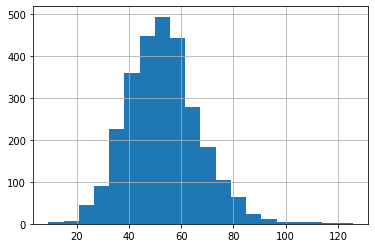

In [53]:
# Plot the histogram to see how exceptional a low rate of mortality is
mhist = pd.to_numeric(fulldf.Mortality_Rate[fulldf.Mortality_Rate != '*'])
print("min", mhist.min(), "max", mhist.max())
#mhist.hist(figsize={14,7}, bins=20)
mhist.hist(bins=20)


If we can show that the counties with asterisks are all low population, then we should treat them as valid and replace them with a low value (eg, 8). If they're not all low-population, then that may suggest that it's noise and we should remove these observations.      

Let us go ahead and bring in some population by county data.  We will grab 3 columns from the dataset: 'POPESTIMATE2015', 'STATE', & 'COUNTY'

In [55]:

cols = ['POPESTIMATE2015', 'STATE', 'COUNTY']

populationdf = pd.read_csv("Cancer Analysis Data Files/CO-EST2015-alldata.csv",encoding = "ISO-8859-1")


In [56]:
populationdf.shape

(3193, 100)

In [57]:
populationdf.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015
0,40,3,6,1,0,Alabama,Alabama,4779736,4780127,4785161,...,0.002295,-0.193196,0.381066,0.582002,-0.467369,1.030015,0.826644,1.383282,1.724718,0.712594
1,50,3,6,1,1,Alabama,Autauga County,54571,54571,54660,...,7.242091,-2.915927,-3.012349,2.265971,-2.530799,7.606016,-2.626146,-2.722002,2.592270,-2.187333
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183193,...,14.832960,17.647293,21.845705,19.243287,17.197872,15.844176,18.559627,22.727626,20.317142,18.293499
3,50,3,6,1,5,Alabama,Barbour County,27457,27457,27341,...,-4.728132,-2.500690,-7.056824,-3.904217,-10.543299,-4.874741,-2.758113,-7.167664,-3.978583,-10.543299
4,50,3,6,1,7,Alabama,Bibb County,22915,22919,22861,...,-5.527043,-5.068871,-6.201001,-0.177537,0.177258,-5.088389,-4.363636,-5.403729,0.754533,1.107861


We have to generate a "FIPS" column by adding leading zeros and concatenating STATE and COUNTY

In [58]:
state = populationdf.STATE.apply(lambda x: str(x))\
                          .str.pad(2, 'left', '0')
county = populationdf.COUNTY.apply(lambda x: str(x))\
                            .str.pad(3, 'left', '0')

populationdf['FIPS'] = state + county

populationdf.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,FIPS
0,40,3,6,1,0,Alabama,Alabama,4779736,4780127,4785161,...,-0.193196,0.381066,0.582002,-0.467369,1.030015,0.826644,1.383282,1.724718,0.712594,01000
1,50,3,6,1,1,Alabama,Autauga County,54571,54571,54660,...,-2.915927,-3.012349,2.265971,-2.530799,7.606016,-2.626146,-2.722002,2.592270,-2.187333,01001
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183193,...,17.647293,21.845705,19.243287,17.197872,15.844176,18.559627,22.727626,20.317142,18.293499,01003
3,50,3,6,1,5,Alabama,Barbour County,27457,27457,27341,...,-2.500690,-7.056824,-3.904217,-10.543299,-4.874741,-2.758113,-7.167664,-3.978583,-10.543299,01005
4,50,3,6,1,7,Alabama,Bibb County,22915,22919,22861,...,-5.068871,-6.201001,-0.177537,0.177258,-5.088389,-4.363636,-5.403729,0.754533,1.107861,01007


Let's merge our population data

In [59]:
# first, let's check to see that the FIPS columns match up properly
print(sum(pd.Series(populationdf.FIPS.unique()).isin(fulldf.FIPS)), 'matches out of')
print("%d unique values" % len(populationdf.FIPS.unique()))

3111 matches out of
3193 unique values


There are more rows in the population dataframe, with 59 FIPS codes in the population dataframe not found in the other dataframe. Let us check in the other direction.

In [60]:
print(sum(pd.Series(fulldf.FIPS.unique()).isin(populationdf.FIPS)), 'matches out of')
print("%d unique values" % len(fulldf.FIPS.unique()))

3111 matches out of
3111 unique values


This shows that all 3134 FIPS values in our full dataframe match with the population dataframe. We can merge the population data and check if the counties whose mortality rates are reported with asterisks are low population.

In [61]:
fulldf = fulldf.merge(populationdf[['FIPS', 'POPESTIMATE2015']], on='FIPS', how='inner')

In [62]:

# Find median as reference point
fulldf.POPESTIMATE2015.median()
print("median, mean population:         %.1f, %.1f" % (fulldf.POPESTIMATE2015.median(),
                                         fulldf.POPESTIMATE2015.mean()))
print("median, mean population '*':      %.1f,   %.1f" % (fulldf.POPESTIMATE2015[fulldf.Mortality_Rate == '*'].median(),
                                            fulldf.POPESTIMATE2015[fulldf.Mortality_Rate == '*'].mean()))
print("median, mean population not '*': %.1f, %.1f" % (fulldf.POPESTIMATE2015[fulldf.Mortality_Rate != '*'].median(),
                                                fulldf.POPESTIMATE2015[fulldf.Mortality_Rate != '*'].mean()))

median, mean population:         25859.0, 103049.9
median, mean population '*':      2981.0,   3922.3
median, mean population not '*': 31212.0, 114178.3


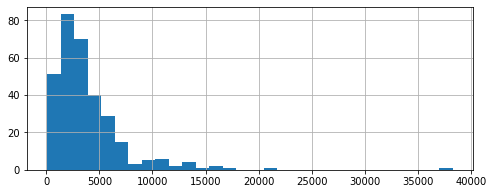

In [63]:
fulldf.POPESTIMATE2015[fulldf.Mortality_Rate == '*'].hist(figsize=(8,3), bins=30);

Yes, the counties with asterisks are definitely lower in population than those without. But,we need to check if they actually had no lung cancer mortalities. It is possible that the low population counties may be less likely to keep and report good data. We need to examine further.

In [64]:
population_levels = [0, 1000, 5000, 10000, 15000, 20000, 50000, 100000, 500000, 10**6]
for i in range(1,len(population_levels)):
    print("population:", "%d-%d" % (population_levels[i-1], population_levels[i]),"median mort. rate:",
                                    fulldf.Mortality_Rate[(fulldf.Mortality_Rate != '*') &
                                                          (population_levels[i-1] < fulldf.POPESTIMATE2015) &
                                                          (fulldf.POPESTIMATE2015 < population_levels[i])].median())

population: 0-1000 median mort. rate: nan
population: 1000-5000 median mort. rate: 57.4
population: 5000-10000 median mort. rate: 51.7
population: 10000-15000 median mort. rate: 54.849999999999994
population: 15000-20000 median mort. rate: 56.3
population: 20000-50000 median mort. rate: 54.3
population: 50000-100000 median mort. rate: 53.5
population: 100000-500000 median mort. rate: 49.3
population: 500000-1000000 median mort. rate: 42.9


Lung cancer mortality rate appears to be higher in lower population counties. That realization raises questions the validity of these "*" missing values. The documentation from the data source states that the records marked by an asterisk indicate fewer than 16 reported cases of mortality from lung cancer. The records with asterisks tend to be very low population. Yet, we've learned that we'd expect in general, they have higher, not lower, mortality rates as compared to higher population counties (in general). 

Let us check how many low-population counties actually did report.

In [65]:
print("Not '*'")
for i in range(1, len(population_levels)):
    print("# records between","%d-%d population" % (population_levels[i-1], population_levels[i]), 
                                      fulldf[(fulldf.Mortality_Rate != '*') &
                                             (fulldf.POPESTIMATE2015 <= population_levels[i]) &
                                             (fulldf.POPESTIMATE2015 > population_levels[i-1])].shape[0]) 


Not '*'
# records between 0-1000 population 0
# records between 1000-5000 population 59
# records between 5000-10000 population 333
# records between 10000-15000 population 320
# records between 15000-20000 population 258
# records between 20000-50000 population 851
# records between 50000-100000 population 386
# records between 100000-500000 population 453
# records between 500000-1000000 population 92


In [66]:
# a closer look at number of records for very low-population counties (< 5000)
print("not '*'")
population_levels = [2500, 3000, 3500, 4000, 4500, 5000]

for i in range(1, len(population_levels)):
    print("# records between","%d-%d population" % (population_levels[i-1], population_levels[i]), 
                                      fulldf[(fulldf.Mortality_Rate != '*') &
                                             (fulldf.POPESTIMATE2015 <= population_levels[i]) &
                                             (fulldf.POPESTIMATE2015 > population_levels[i-1])].shape[0]) 

print("'*'") 
for i in range(1, len(population_levels)):
    print("# records between","%d-%d population" % (population_levels[i-1], population_levels[i]), 
                                      fulldf[(fulldf.Mortality_Rate == '*') &
                                             (fulldf.POPESTIMATE2015 <= population_levels[i]) &
                                             (fulldf.POPESTIMATE2015 > population_levels[i-1])].shape[0]) 

not '*'
# records between 2500-3000 population 2
# records between 3000-3500 population 5
# records between 3500-4000 population 14
# records between 4000-4500 population 19
# records between 4500-5000 population 17
'*'
# records between 2500-3000 population 32
# records between 3000-3500 population 27
# records between 3500-4000 population 23
# records between 4000-4500 population 20
# records between 4500-5000 population 9


We have now gathered quite a bit of information that we can use to decide what to do with the observations where mortality rate is missing.   

Since mortality rate is our target variable, we probably could have skipped all this investigation and opted to simply remove the missing records. However, it was a worthwhile exercise to walk through. We can now remove the rows with missing mortality rate values entirely. Here are some reasons:
* Low-population counties are already well-represented in the data (there are plenty of non-null observations).
* It seems redundant (and a source of unnecessary noise) to impute missing values in the outcome variable in this case.
* It's safe to treat the null values as if they were randomly drawn (they may not be entirely random, but it seems unlikely that we are losing much information at this time by removing them).
* Given that lower populations tend (when they do report) to have higher mortality rates, it is misleading to state that the asterisks represent counties which reported "fewer than 16" cases of mortality. Instead, the asterisks more likely represent counties which failed to collect and/or report mortality data. Note that we are dealing with normalized mortality rates -- per capita (100,000). 

This may seem arbitrary. Keep in mind data science involves many subjective decisions! Just be sure that you have done your due diligence and can explain and defend your decision-making process.    
      
Now, we are going to filter out the records with missing mortality rate values.

In [67]:
fulldf = fulldf[fulldf.Mortality_Rate != '*']

### We still need to clean up Med_Income, Incidence_Rate, Avg_Ann_Incidence, and Avg_Ann_Deaths

In [68]:
# Med_Income
fulldf['Med_Income'] = pd.to_numeric(fulldf.Med_Income)  # That was easy!

In [69]:
# Incidence_Rate
# Let's use this script to see which values fail to convert to numeric:
values = []
for _, j in enumerate(fulldf.Incidence_Rate):
    try:
        pd.to_numeric(j)
    except:
        values.append(j)
        
pd.Series(values).value_counts()[:10]

_            151
__            12
*              5
68.2 #         2
71.1 #         2
73.6 #         2
75.6 #         1
39.3 #         1
104.9 #        1
69.7 #         1
dtype: int64

It appears that there are four different types of values that cannot be converted into numeric values.    
 
We already decided that we are going to omit any records where Mortality_Rate is missing (asterisk).   
We see that | and || also indicate missing values due to legislative reasons, and no data from Nevada, respectively.    
The hash sign means "Data do not include cases diagnosed in other states for those states in which the data exchange agreement specifically prohibits the release of data to third parties."   

How should we proceed? Well, mortality rate is our target variable. Also, it's arguably a more interesting variable and it's already clean and homogenous. So, if we remove any additional rows, we're losing good mortality rate data. So, it is better if we not omit any rows in order to fix Incidence_Rate. For now, let us leave incidence rate alone. If we want to include it in our explanatory variables, we can consider imputing the missing values. Otherwise, if we want to create a model with it as the outcome, we can deal with that separately. 

### Avg_Ann_Incidence and Avg_Ann_Deaths     
These values are closely related to the Incidence_Rate and Mortality_Rate variables, respectively. It is safe to assume that we are more interested in these values normalized by population (rates rather than raw values). So, they are redundant since we already have information about mortality and incidence rates, as well as county population.

### Now, we can now get the data ready for a model

In [72]:
fulldf.head()

,state,All_Poverty,M_Poverty,F_Poverty,areaname,FIPS,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
0,AL,7057,2983,4074,"Autauga County, Alabama",01001,51281.0,23500,2781,25417,2727,48917,5508,74.9,43,59.3,34,55347
1,AL,25798,12018,13780,"Baldwin County, Alabama",01003,50254.0,79768,13644,88015,11343,167783,24987,66.9,170,48,121,203709
2,AL,6421,2856,3565,"Barbour County, Alabama",01005,32964.0,9578,2163,10750,1569,20328,3732,74.6,25,61.3,20,26489
3,AL,3488,1495,1993,"Bibb County, Alabama",01007,38678.0,9342,1012,9421,995,18763,2007,86.4,23,67.8,17,22583
4,AL,9552,4593,4959,"Blount County, Alabama",01009,45813.0,24629,3642,25922,3017,50551,6659,69.7,51,59.9,43,57673


In [70]:
# create dummy variables for "Recent Trend"

# rename 'Recent Trend' to remove the space
fulldf.rename(columns={'Recent Trend':'RecentTrend'}, inplace=True)

# change all the missing values to the mode ('stable')
fulldf.replace({'RecentTrend' : {'*':'stable'}}, inplace=True)

# function to do boolean check and return 1 or 0
def f(x, term):
    if x == term:
        return 1
    else:
        return 0

# create new features using the apply method with the 'f' function we defined above
fulldf['Rising'] = fulldf.RecentTrend.apply(lambda x: f(x, term='rising'))
fulldf['Falling'] = fulldf.RecentTrend.apply(lambda x: f(x, term='falling'))

# Note that of the 3 levels of RecentTrend, we only created dummies for rising and falling
# We will be incuding constant in our model (dummy variable trap)

AttributeError: 'DataFrame' object has no attribute 'RecentTrend'

In [71]:
fulldf['RecentTrend'].value_counts()

KeyError: 'RecentTrend'

In [ ]:
y = pd.to_numeric(fulldf.Mortality_Rate).values
X = fulldf.loc[:,['All_Poverty', 'M_Poverty', 'F_Poverty', 'Med_Income',
            'M_With', 'M_Without', 'F_With', 'F_Without', 'All_With',
            'All_Without', 'Incidence_Rate', 'Falling', 'Rising',
            'POPESTIMATE2015']]

In [ ]:
X.head()

It is important to convert our numeric data to per capita. Our target variable, mortality rate, is measured per 100,000 population. By normalizing each variable to 100,000 population, we can objectively assess how they correlate with each other. In case we want to account for the influence of population in our model, we can also retain the population feature.     
     
The Incidence_Rate feature contains some values (eg, '\*', '||', & '|') that we need to deal with before we can convert them into numeric format. Let's do that now. Fortunately, pandas makes this quite easy.

The "errors='coerce'" argument to the pd.to_numeric method, tells pandas to replace any value that cannot be converted to a float with 'nan'.

In [ ]:
X['Incidence_Rate'] = pd.to_numeric(X.Incidence_Rate, errors='coerce')

Now we can use the pandas fillna() method to easily impute the missing values. While it's tempting to use a more complex technique to impute the missing values (like random forest regression, for example), imputing using the mean or median is much simpler and is likely to yield pretty comparable results.

In [ ]:
X['Incidence_Rate'] = X.Incidence_Rate.fillna(X.Incidence_Rate.median())
print(sum(X.Incidence_Rate.isnull()))

We will now convert the applicable variables to per capita. We will retain the original features and name the per capita versions with the "_PC" suffix.

In [ ]:
for col in ['All_Poverty', 'M_Poverty', 'F_Poverty', 'M_With',
            'M_Without', 'F_With', 'F_Without', 'All_With', 'All_Without']:
       
    X[col + "_PC"] = X[col] / X.POPESTIMATE2015 * 10**5

In [ ]:
X.head()

## Perform Visual Exploratory Analysis

In [ ]:
# scatterplots (hat tip Sebastian Raschka from his book "Python Machine Learning")
sns.set(style='whitegrid', context='notebook')
sns.pairplot(X[['All_Poverty_PC', 'M_Poverty_PC', 'F_Poverty_PC', 'Med_Income']], height=2)
plt.show()

In [ ]:
cols = ['All_Poverty_PC', 'M_Poverty_PC', 'F_Poverty_PC', 'Med_Income']
cm = np.corrcoef(X[['All_Poverty_PC', 'M_Poverty_PC', 'F_Poverty_PC', 'Med_Income']].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15},
                 yticklabels=cols, xticklabels=cols)
plt.show()

Note that All_Poverty_PC, F_Poverty_PC and M_Poverty_PC look perfectly correlated. We don't want redundant features. So we will drop M_Poverty_PC and F_Poverty_PC and keep only All_Poverty_PC to represent poverty information in our model.

In [ ]:
X.drop(['M_Poverty_PC', 'F_Poverty_PC'], axis=1, inplace=True)

After repeating this process with our health insurance variables, it became clear that the gender-specific features are redundant. After removing them, we're left with these data:

In [ ]:
X.drop(['M_With_PC', 'F_With_PC'], axis=1, inplace=True)
X.drop(['M_Without_PC', 'F_Without_PC'], axis=1, inplace=True)
X.head()

Now that we've removed all the redundant data, let's look at the correlations with the remaining features.

In [ ]:
cols = ['All_Poverty_PC', 'Med_Income', 'All_With_PC', 'All_Without_PC',
                'Incidence_Rate', 'POPESTIMATE2015']
sns.set(style='whitegrid', context='notebook')
sns.pairplot(X[cols], height=2)
plt.show()

In [ ]:
cm = np.corrcoef(X[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15},
                 yticklabels=cols, xticklabels=cols)
plt.show()

There are a couple pairs of fairly strongly correlated features: (All_Poverty_PC & Med_Income) and (All_With_PC & All_Without_PC). We'll keep them in mind as we observe how they work in the linear regression.

# 3. Linear Regression Model

In [ ]:
cols = ['All_Poverty_PC', 'Med_Income', 'All_With_PC',  'All_Without_PC',
        'Incidence_Rate', 'POPESTIMATE2015', 'Falling', 'Rising', 'All_Poverty',
        'All_With', 'All_Without']

In [ ]:
# add constant (coloumn vector of all 1s)
X = X[cols]
X['Constant'] = 1
X.reset_index(drop=True, inplace=True)

In [ ]:
# Fit linear regression model
lr = sm.OLS(y, X, hasconst=True)
result = lr.fit()

In [ ]:
result.summary()

After fitting an ordinary least squares model with the ['All_Poverty_PC', 'Med_Income', 'All_With_PC', All_Without_PC', 'Incidence_Rate', 'POPESTIMATE2015', 'Falling', 'Rising', 'All_Poverty', 'All_With', 'All_Without'] regressed on the Mortality_Rate target variable, we have a pretty well-performing model, as evidenced by the Adjusted R^2 (738).   
    
Let's treat this as our baseline, and apply model diagnostics and feature selection to try to improve it.   

We will attempt to account for multicollinearity, heteroscedsticity of residuals, and normality of distributions of residuals.     
       
#### Multicollinearity     
Let's apply variance inflation factors to assess for multicollinearity. VIFs, by performing an independent variable on the design matrix comprising all the other independent variables, allows us to assess the degree to which that independent variable is orthogonal the others. Larger VIFs indicate multicollinearity.     

VIF values exceeding 10 are commonly interpreted as "high" in multicollinearity. However, this threshold is arbitrary, and it may make sense to select a different threshold in many cases.

In [ ]:
pd.DataFrame([[var, variance_inflation_factor(X.values, X.columns.get_loc(var))] for var in X.columns],
                   index=range(X.shape[1]), columns=['Variable', 'VIF'])


After iteratively removing the feature associated with the largest VIF and then recalculating VIFs, we result in these independent variables:

In [ ]:
X.columns

In [ ]:
vcols = ['All_Poverty_PC', 'Med_Income', 'All_With_PC', 'All_Without_PC',
       'Incidence_Rate', 'Falling', 'Rising', 'Constant']

In [ ]:
Xvcols = X[vcols].reset_index(drop=True)
pd.DataFrame([[var, variance_inflation_factor(Xvcols.values, Xvcols.columns.get_loc(var))] for var in vcols],
                   index=range(len(vcols)), columns=['Variable', 'VIF'])

Interestingly, All_Without (men and women without health insurance), versus the same per capita (All_Without_PC) don't indicate high multicollinearity. It is unclear what to make of that. In any case, let us remove All_Without from the model because it is more or less a proxy for population.
     
Let's recompute a linear regression on the reduced set of independent variables.

In [ ]:
vcols = ['All_Poverty_PC', 'Med_Income', 'All_Without_PC',
       'Incidence_Rate', 'Falling', 'POPESTIMATE2015', 'Constant']
Xvcols = X[vcols].reset_index(drop=True)
lr = sm.OLS(y, Xvcols, hasconst=True)
result = lr.fit()

In [ ]:
result.summary()

I'm satisfied with how this model looks. Specifically: 

1. VIFs indicate that it's not afflicted by multicollinearity, 

2. all the parameters are statistically significant (P>|t|),  

3. all the parameters logically make sense (eg, oriented in directions that logically make sense).   
    
Let's move on and take a look at residuals to assess for normality and heteroscedasticity.   

**Are residuals normally distributed?**

In [ ]:
# histogram superimposed by normal curve
plt.figure(figsize=(10,6))
import scipy.stats as stats
mu = np.mean(result.resid)
sigma = np.std(result.resid)
pdf = stats.norm.pdf(sorted(result.resid), mu, sigma)
plt.hist(result.resid, bins=100)
plt.plot(sorted(result.resid), pdf, color='r', linewidth=2)
plt.show()

The distribution of the residuals does not adhere perfectly to a normal distribution (skew=0, excess kurtosis=0). There is a small number of outliers to the left, the tails appear slightly fatter than, and the distribution has somewhat larger kurtosis than the normal distribution. 

In [ ]:
# QQplot
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,3))
sm.qqplot(result.resid, stats.t, fit=True, line='45', ax = ax1)
ax1.set_title("t distribution")
sm.qqplot(result.resid, stats.norm, fit=True, line='45', ax=ax2)
ax2.set_title("normal distribution")
plt.show()

The qqplots confirm that the residuals adhere more closely to the t- than normal distribution (fatter tails). A few prominent outliers are visible at the lower extreme.   
      
All-in-all, despite these imperfections, the distribution of residuals is rather adequate. However, we should investigate the nature of the more extreme outliers. We also may want to try to add additional information to the model (new variable(s)), in light of the the model's tendency to overestimate low values and underestimate high values.

**Heteroscedasticity**   

In [ ]:
# plot predicted vs actual
plt.figure(figsize=(14,7))
sns.regplot(y, result.fittedvalues, line_kws={'color':'r', 'alpha':0.3, 
                                              'linestyle':'--', 'linewidth':2}, 
            scatter_kws={'alpha':0.5})
plt.ylim(0,160)
plt.xlabel('Actual Values')
plt.ylabel('Fitted Values')
plt.show()
print("Pearson R: ", stats.pearsonr(result.fittedvalues, y))

Consistent with our reported R^2 value, we now visualize the strong correlation between actual and predicted values.

In [ ]:
# plot actual values versus residuals
from statsmodels.nonparametric.smoothers_lowess import lowess
ys = lowess(result.resid.values, y, frac=0.2)
ys = pd.DataFrame(ys, index=range(len(ys)), columns=['a', 'b'])
ys = ys.sort_values(by='a')

fig, ax = plt.subplots(figsize=(14,9))
plt.scatter(y, result.resid, alpha=0.5, s=25)
plt.axhline(y=0, color='r', linestyle="--", alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")

plt.plot(ys.a, ys.b, c='green', linewidth=2, label="Lowess")
plt.legend()
plt.show()
print("Pearson R:", stats.pearsonr(y, result.resid))

This chart suggests that the model tends to somewhat overshoot lower values, and undershoot higher ones. 

In [ ]:
# plot actual values versus residuals
plt.figure(figsize=(14,7))
plt.scatter(y=result.resid, x=result.fittedvalues, alpha=0.5, s=22)
plt.axhline(y=0, color='r', linestyle="--", alpha=0.5)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.ylim(-65, 50)
plt.show()

The plot of residuals versus fitted values shows that the residuals are fairly symmetric relative to the fitted values.

### Model Diagnostics Summary      
* Multicollinearity does not appear to be present.
* Parameters are statistically significant.
* The residuals adhere more closely to a t- than a normal distribution -- larger excess kurtosis and fatter tails.
* The fitted values tend to err in the negative direction (overestimate) actual values toward the lower extreme of the range, and the inverse for values toward the high end of the range.
* The adjusted R^2 is 0.74, meaning that the model accounts for 74% of the total observed variance in the target.
* improvements to the model should focus on accounting for outliers and, if possible, adding additional information to the model.